# Audio Noise Separation

Proposed Algorithm :
1. Load Audio
2. Convert it from time domain data to frequency domain data using FFT(Fast Fourier Transformation)
3. Perform Calculations(Separate noise from audio)
4. Apply Inverse Fourier Transformation on extracted audios
5. Export Audios


Resources : 
- [Understanding Audio data](https://towardsdatascience.com/understanding-audio-data-fourier-transform-fft-spectrogram-and-speech-recognition-a4072d228520)

In [1]:
import librosa
from librosa import display
from IPython.display import Audio
import matplotlib.pyplot as plt
import scipy
import numpy as np
import soundfile as sf
from sklearn.cluster import SpectralClustering

## Step 1 : Load Audio

In [2]:
# loading audio
def load_audio(filepath):
    samples, sampling_rate = librosa.load(filepath, sr = None, mono = True, offset = 0.0, duration = None)
    return samples, sampling_rate
    
file_path = "./data/sample4/overlaid.wav"
samples, sampling_rate = load_audio(file_path)
len(samples), sampling_rate

(133306, 44100)

In [3]:
# duration
duration_of_sound = len(samples) / sampling_rate
print("Duration of audio :", duration_of_sound, "seconds")

Duration of audio : 3.0228117913832198 seconds


In [4]:
Audio(file_path)

### Time domain representation

In [5]:
 def plot_waveshow_td_representation(audio, sampling_rate):
    plt.figure(figsize=(15,7))
    display.waveshow(y = audio, sr = sampling_rate)
    plt.xlabel("Time (in seconds)")
    plt.ylabel("Amplitude")
    return plt.show()

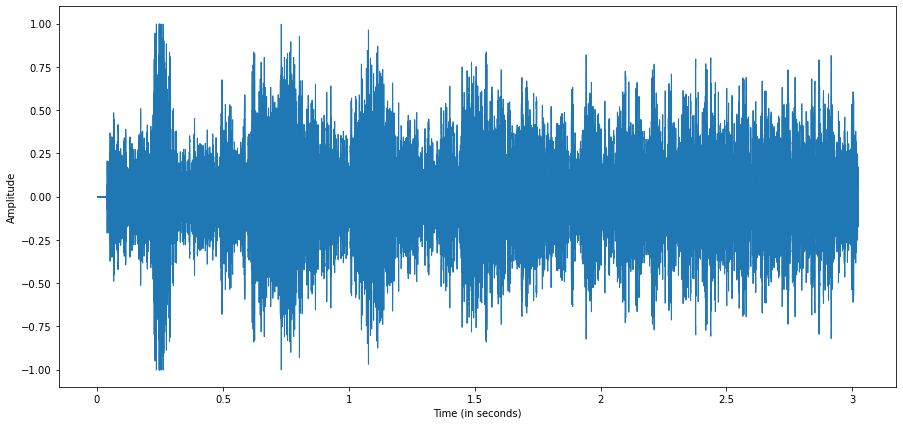

In [6]:
plot_waveshow_td_representation(samples, sampling_rate)

## Step 2 : Apply Fourier Transform

### Frequency domain representation

In [7]:
def perform_fft(audio, sampling_rate):
    n = len(audio)
    T = 1/sampling_rate
    frequency_data = scipy.fft.fft(audio)
    magnitude = np.linspace(0.0, 1.0/(2.0*T), n//2)
    return frequency_data, magnitude

In [8]:
def plot_fd_representation(frequency_data, magnitude):
    plt.rcParams["figure.figsize"] = [15, 7]
    n = len(frequency_data)
    fig, ax = plt.subplots()
    ax.plot(magnitude, 2.0/n * np.abs(frequency_data[:n//2]))
    plt.grid()
    plt.xlabel("Frequency ->")
    plt.ylabel("Magnitude")
    return plt.show()

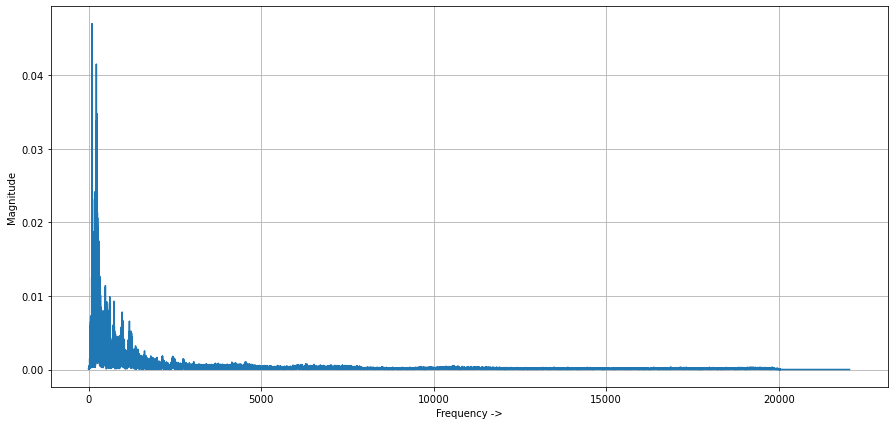

In [9]:
frequency_data, magnitude = perform_fft(samples, sampling_rate)
plot_fd_representation(frequency_data, magnitude)

### Spectrogram

In [10]:
def scatterReady(spec):
    rows, columns = spec.shape
    X = np.zeros((columns*rows, 3))
    i = 0
    for r in range(0, rows):
        for c in range(0, columns):
            X[i, :] = (c, r, spec[r, c])
            i = i + 1
    return X

In [11]:
specgram_data_final = librosa.stft(samples, n_fft=4096, hop_length=128)  # full
specgram_data = librosa.stft(
    samples, n_fft=1364, hop_length=3600, dtype=np.float64)  # low
rows, columns = specgram_data.shape
print('\nRunning audio analysis with data of', specgram_data.shape, '\n')
print('Original spectrogram size is:', specgram_data_final.shape, '\n')


Running audio analysis with data of (683, 38) 

Original spectrogram size is: (2049, 1042) 



/home/debashish/miniconda3/envs/mini-project/lib/python3.10/site-packages/librosa/core/spectrum.py:254: ComplexWarning: Casting complex values to real discards the imaginary part
  stft_matrix[..., bl_s:bl_t] = fft.rfft(


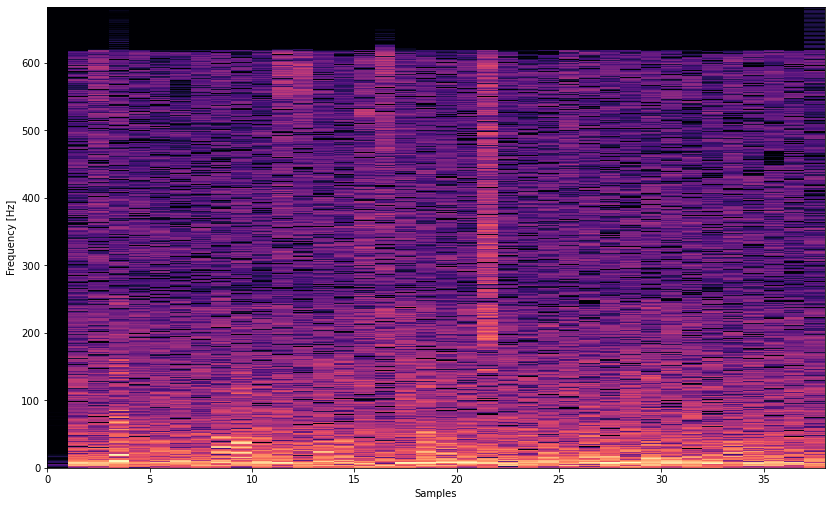

In [12]:
plt.figure(1).set_size_inches(12, 8)
plt.figure(1).subplots_adjust(left=0.05, bottom=0.1,
                              right=0.95, top=0.9, wspace=0.6, hspace=0.8)
plt.pcolormesh(librosa.amplitude_to_db(specgram_data), cmap='magma')
plt.ylabel('Frequency [Hz]')
plt.xlabel('Samples')
plt.show()

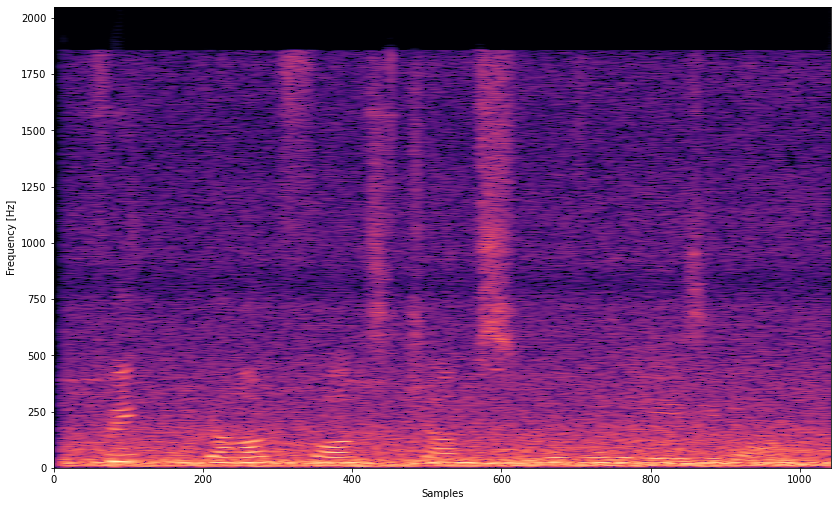

In [82]:
plt.figure(1).set_size_inches(12, 8)
plt.figure(1).subplots_adjust(left=0.05, bottom=0.1,
                              right=0.95, top=0.9, wspace=0.6, hspace=0.8)
plt.pcolormesh(librosa.amplitude_to_db(specgram_data_final), cmap='magma')
plt.ylabel('Frequency [Hz]')
plt.xlabel('Samples')
plt.show()

## Step 3 : Perform Calculations

-> Clustering column progress (total no.  38 :) 0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31, 32, 33, 34, 35, 36, 37, 

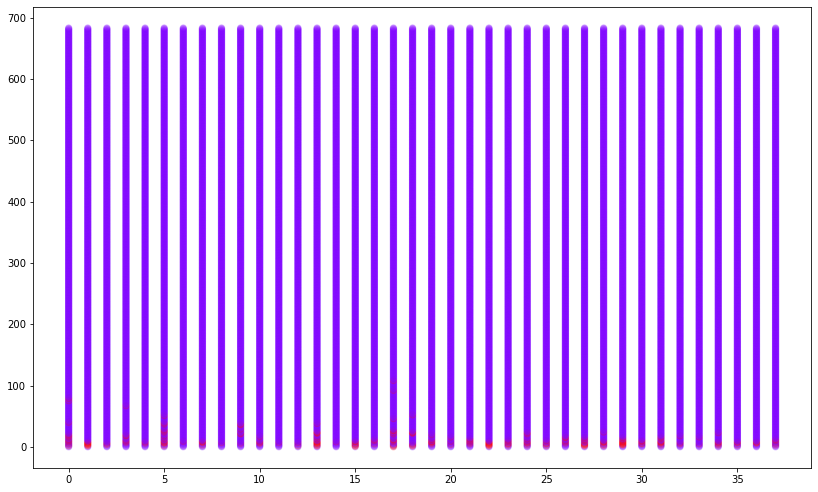

In [45]:
import warnings
warnings.filterwarnings(action='ignore')

# spectral = SpectralClustering(n_clusters=2)
# spectral = SpectralClustering(n_clusters=2, eigen_solver='arpack', affinity="nearest_neighbors", n_jobs=-1, assign_labels='kmeans')
# spectral = SpectralClustering(n_clusters=2, eigen_solver='arpack', affinity="rbf", n_jobs=-1, assign_labels='kmeans')
spectral = SpectralClustering(n_clusters=2, affinity="rbf", n_jobs=-1, assign_labels='discretize')
all_labels = np.zeros((rows, columns))

plt.figure(2).set_size_inches(12, 8)
plt.figure(2).subplots_adjust(left=0.05, bottom=0.1,
                              right=0.95, top=0.9, wspace=0.6, hspace=0.8)

print('-> Clustering column progress (total no. ', columns, ':)', end=' ')
for col in range(0, columns):
    spectral_fit_predict = spectral.fit_predict(
        specgram_data[:, col].reshape(-1, 1))
    print(col, ", ", end='', sep='')
    all_labels[:, col] = spectral_fit_predict
    x = np.full((rows, 1), col)
    y = np.linspace(0, rows, rows)
    plt.scatter(x, y, c=spectral_fit_predict, s=40, cmap="rainbow", alpha=0.2)

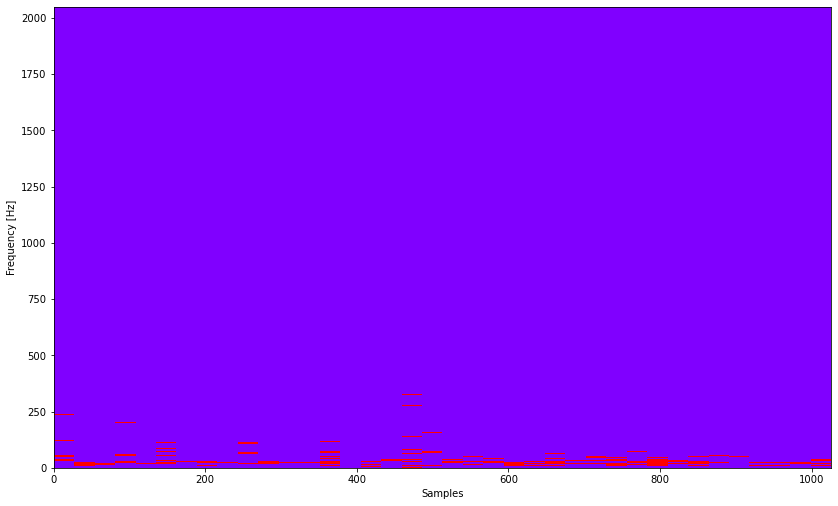

In [46]:
# creating an array of lables in the size of the original recording
all_labels = np.repeat(all_labels, int(
    specgram_data_final.shape[0]/specgram_data.shape[0]), axis=0)
all_labels = np.repeat(all_labels, int(
    specgram_data_final.shape[1]/specgram_data.shape[1]), axis=1)

plt.figure(3).set_size_inches(12, 8)
plt.figure(3).subplots_adjust(left=0.05, bottom=0.1,
                              right=0.95, top=0.9, wspace=0.6, hspace=0.8)
plt.pcolormesh(all_labels, cmap="rainbow")
plt.ylabel('Frequency [Hz]')
plt.xlabel('Samples')
plt.show()

In [63]:
spectragram2 = np.copy(specgram_data_final)
spectragram3 = np.copy(specgram_data_final)
rows2, columns2 = spectragram2.shape

'''--------------------
generating result01: all noise = 0
--------------------'''
# for r in range(0, rows2):
#     for c in range(0, min(columns2, all_labels.shape[1])):
#         if all_labels[r, c] == 0:
#             spectragram2[r, c] = 0
#         else:
#             spectragram3[r, c] = 0
            
'''--------------------
# generating result02: remove only possitive value
# --------------------'''
# spectragram2 = np.copy(specgram_data_final)
# rows2, columns2 = spectragram2.shape

# for r in range(0, rows2):
#     for c in range(0, min(columns2, all_labels.shape[1])):
#         if all_labels[r, c] == 0:
#             if spectragram2[r, c] > 0:
#                 spectragram2[r, c] = 0
                

'''--------------------
generating result03: reduce possitive values
--------------------'''
# spectragram2 = np.copy(specgram_data_final)
# rows2, columns2 = spectragram2.shape

# for r in range(0, rows2):
#     for c in range(0, min(columns2, all_labels.shape[1])):
#         if all_labels[r, c] == 0:
#             if spectragram2[r, c] > 0:
#                 spectragram2[r, c] = spectragram2[r, c] * 0.2
                

'''--------------------
generating result04: reduce all
--------------------'''
spectragram2 = np.copy(specgram_data_final)
rows2, columns2 = spectragram2.shape

for r in range(0, rows2):
    for c in range(0, min(columns2, all_labels.shape[1])):
        if all_labels[r, c] == 0:
            spectragram2[r, c] = spectragram2[r, c] * 0.2

## Step 4 : Perform Inverse Fourier Transform

### Inverse fourier transform

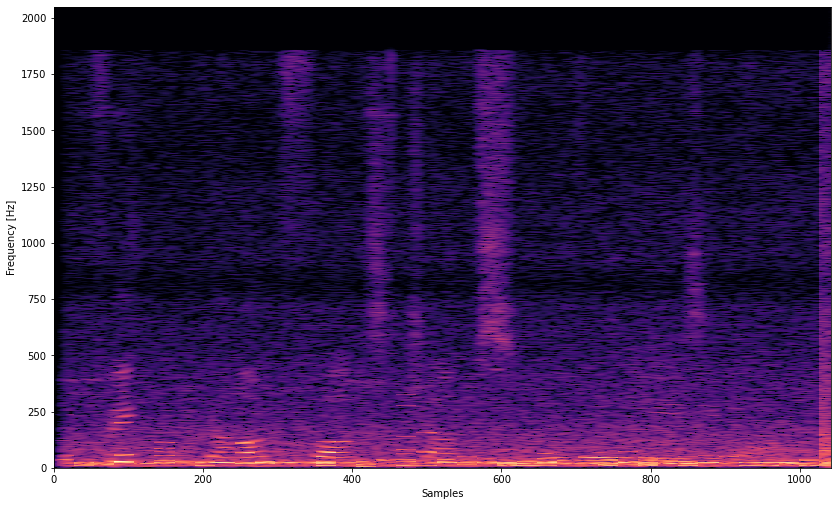

In [64]:
output1 = librosa.core.istft(spectragram2, win_length=4096, hop_length=128)
output2 = librosa.core.istft(spectragram3, win_length=4096, hop_length=128)
plt.figure(4).set_size_inches(12, 8)
plt.figure(4).subplots_adjust(left=0.05, bottom=0.1,
                              right=0.95, top=0.9, wspace=0.6, hspace=0.8)
plt.pcolormesh(librosa.amplitude_to_db(spectragram2), cmap="magma")
plt.ylabel('Frequency [Hz]')
plt.xlabel('Samples')
plt.show()

## Step 5 : Extract Audio

In [54]:
def extract_audio(filename, audio, sampling_rate):
    sf.write(filename, audio, samplerate=sampling_rate)
    print("Extracted Successfully")

In [68]:
extract_audio('./output/output1.wav', output1, sampling_rate)

Extracted Successfully


### Step 6 : Increase Amplitude

In [76]:
output_enchanced = [o + 0.2 for o in output1]

In [80]:
print(max(output1), min(output1))
print(max(samples), min(samples))
print(max(output_enchanced), min(output_enchanced))

0.7045924 -0.7474391
0.9999695 -1.0
0.9045924067497253 -0.5474390864372254


In [81]:
extract_audio('./output/output_e.wav', output_enchanced, sampling_rate)

Extracted Successfully
